# KMP Performance Analysis (with Regex Baseline)

This notebook analyzes KMP performance using `benchmark_results.json` and augments it with a Python `re` (regex) baseline for apples-to-apples comparisons on the same synthetic setups.

We will generate:

1. Search Time vs Text Length (n)
2. Search Time vs Pattern Length (m)
3. Real dataset performance summary (and optional regex baseline if datasets are available locally)
4. Brief pass/fail summary of unit-style tests captured by the benchmark suite

Where feasible, we reconstruct the exact synthetic inputs used by the benchmark (same seeds and pattern generation) to time regex under identical conditions.

## Phase 1: Setup and Imports

We import pandas, seaborn, matplotlib, numpy, and utilities for synthetic DNA generation. We'll also use Python's `re` for the regex baseline and `time` for simple wall-clock measurements.

### About the next cell (Setup and configuration)
This cell imports project utilities and plotting libraries, configures output directories and styles, and loads benchmark data from `benchmark_results.json`. If the file is missing, it instructs you to run `benchmark.py` first. It also defines small helpers for extracting specific benchmark sections and for detecting the local dataset root.

In [6]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import time

# Utilities from this package
from utils import generate_random_dna, get_all_fasta_files, read_fasta_sequences_only

# --- Configuration ---
JSON_FILE = "benchmark_results.json"
OUTPUT_DIR = "graphs"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set plot style
sns.set_theme(style="whitegrid")

# --- Load Data ---
if not os.path.exists(JSON_FILE):
    raise FileNotFoundError(f"Benchmark file '{JSON_FILE}' not found. Run benchmark.py first.")

with open(JSON_FILE, 'r') as f:
    data = json.load(f)

benchmarks = data.get('benchmarks', [])
print(f"Loaded benchmark data generated on: {data.get('timestamp', 'Unknown date')}")

# Helper to extract specific benchmark types into a DataFrame
def get_benchmark_df(bench_type):
    for b in benchmarks:
        if b.get('benchmark_type') == bench_type:
            return pd.DataFrame(b['results'])
    return pd.DataFrame()

def find_benchmark(bench_type):
    return next((b for b in benchmarks if b.get('benchmark_type') == bench_type), None)

def detect_dataset_root():
    """Locate the ncbi_dataset/data folder robustly in a Notebook (no __file__).
    Strategy: walk upwards from the current working directory and test common relative locations."""
    try:
        cwd = os.getcwd()
    except Exception:
        cwd = os.path.abspath(".")
    anchors = [cwd]
    # Walk up a few levels just in case the kernel cwd is inside subfolders
    for _ in range(5):
        parent = os.path.dirname(anchors[-1])
        if parent == anchors[-1]:
            break
        anchors.append(parent)
    candidates = []
    for base in anchors:
        candidates.append(os.path.join(base, 'DnA_dataset', 'ncbi_dataset', 'data'))
        # Also check sibling-of-current if we're inside module subfolders (e.g., .../STARK/KMP)
        candidates.append(os.path.abspath(os.path.join(base, '..', 'DnA_dataset', 'ncbi_dataset', 'data')))
        candidates.append(os.path.abspath(os.path.join(base, '..', '..', 'DnA_dataset', 'ncbi_dataset', 'data')))
    for p in candidates:
        if os.path.exists(p):
            return p
    return None

Loaded benchmark data generated on: 2025-11-18T14:35:56.304848


## Graph 1: Search Time vs Text Length (n)

Fixed pattern length; we compare KMP and regex on identical synthetic inputs (same seeds) and show time vs n.

### About the next cell (Graph 1: n vs time)
- Reconstructs the synthetic inputs used by the benchmark to time regex under identical conditions.
- Plots KMP vs Regex time (ms) against text length n, with KMP’s average processing speed annotated.
- Prints a quick ratio of Regex/KMP per n for context.

Graph 1 saved to graphs/graph1_time_vs_text_length.png


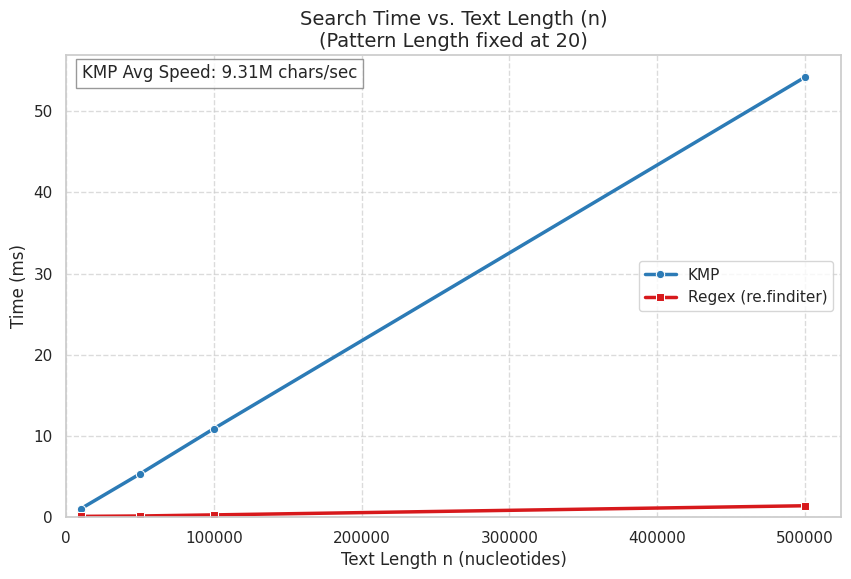

Regex/KMP time ratio at n=10,000: 0.1×
Regex/KMP time ratio at n=50,000: 0.0×
Regex/KMP time ratio at n=100,000: 0.0×
Regex/KMP time ratio at n=500,000: 0.0×


In [31]:
# Extract text length benchmark data
df_text = get_benchmark_df('text_length')

if not df_text.empty:
    # Reconstruct synthetic inputs used by benchmark.py for fair regex baseline:
    # pattern = generate_random_dna(pattern_length, seed=42)
    # text for each length: generate_random_dna(length, seed=100)
    pattern_len = int(df_text['pattern_length'].iloc[0])
    pattern = generate_random_dna(pattern_len, seed=42)

    regex_times_ms = []
    for length in df_text['text_length']:
        text = generate_random_dna(int(length), seed=100)
        pat_re = re.compile(pattern)
        t0 = time.time()
        # Use finditer to simulate full match enumeration (as KMP returns all positions)
        _ = [m.start() for m in pat_re.finditer(text)]
        t1 = time.time()
        regex_times_ms.append((t1 - t0) * 1000)

    plt.figure(figsize=(10, 6))
    
    # Plot KMP: Time vs Text Length
    sns.lineplot(
        data=df_text, 
        x="text_length", 
        y="time_ms", 
        marker="o", 
        linewidth=2.5,
        color="#2c7bb6",
        label="KMP"
    )
    
    # Overlay Regex baseline
    sns.lineplot(
        x=df_text['text_length'],
        y=regex_times_ms,
        marker="s",
        linewidth=2.5,
        color="#d7191c",
        label="Regex (re.finditer)"
    )
    
    # Calculate and display average processing rate for KMP
    avg_rate = df_text['chars_per_second'].mean() / 1_000_000  # Million chars/sec
    
    plt.title(f"Search Time vs. Text Length (n)\n(Pattern Length fixed at {pattern_len})", fontsize=14)
    plt.xlabel("Text Length n (nucleotides)", fontsize=12)
    plt.ylabel("Time (ms)", fontsize=12)
    
    # Force axes to start at 0 to visualize linearity correctly
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    
    # Add annotation for processing speed (KMP)
    plt.text(0.02, 0.95, f"KMP Avg Speed: {avg_rate:.2f}M chars/sec", 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend()
    
    output_path = os.path.join(OUTPUT_DIR, "graph1_time_vs_text_length.png")
    plt.savefig(output_path, dpi=200, bbox_inches="tight")
    print(f"Graph 1 saved to {output_path}")
    plt.show()

    # Print quick ratio summary
    ratios = (np.array(regex_times_ms) / df_text['time_ms'].to_numpy())
    for n, r in zip(df_text['text_length'], ratios):
        print(f"Regex/KMP time ratio at n={int(n):,}: {r:.1f}×")
else:
    print("No data found for 'text_length' benchmark.")

## Graph 2: Search Time vs Pattern Length (m)

Fixed text length; we reconstruct the same text and slice patterns from it as in the benchmark to compare KMP and regex.

### About the next cell (Graph 2: m vs time)
- Recreates the fixed text used during benchmarking and slices patterns from it so both KMP and Regex see identical inputs.
- Plots time (ms) vs pattern length m for KMP and Regex.

Graph 2 saved to graphs/graph2_time_vs_pattern_length.png


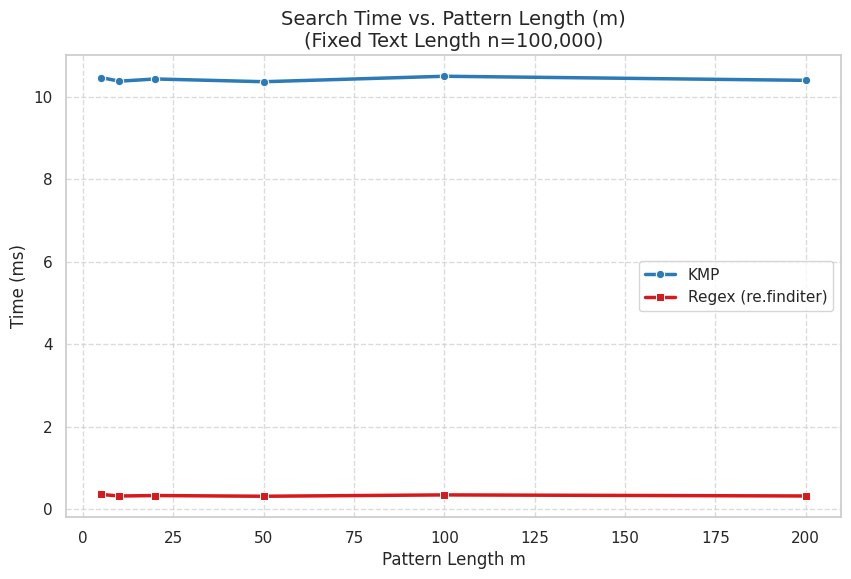

In [32]:
# Extract pattern length benchmark data
df_pat = get_benchmark_df('pattern_length')

if not df_pat.empty:
    fixed_n = int(df_pat['text_length'].iloc[0])
    # Reconstruct the exact text and patterns used by benchmark.py
    text = generate_random_dna(fixed_n, seed=42)
    regex_times_ms = []
    for m in df_pat['pattern_length']:
        m = int(m)
        pattern = text[1000:1000+m]
        pat_re = re.compile(pattern)
        t0 = time.time()
        _ = [mm.start() for mm in pat_re.finditer(text)]
        t1 = time.time()
        regex_times_ms.append((t1 - t0) * 1000)

    plt.figure(figsize=(10, 6))
    
    # Plot Time vs Pattern Length for KMP
    sns.lineplot(
        data=df_pat, 
        x="pattern_length", 
        y="time_ms", 
        marker="o", 
        linewidth=2.5,
        color="#2c7bb6",
        label="KMP"
    )
    
    # Overlay Regex baseline
    sns.lineplot(
        x=df_pat['pattern_length'],
        y=regex_times_ms,
        marker="s",
        linewidth=2.5,
        color="#d7191c",
        label="Regex (re.finditer)"
    )
    
    plt.title(f"Search Time vs. Pattern Length (m)\n(Fixed Text Length n={fixed_n:,})", fontsize=14)
    plt.xlabel("Pattern Length m", fontsize=12)
    plt.ylabel("Time (ms)", fontsize=12)
    
    # Keep focus on absolute times; no tight ylim to avoid clipping regex at small m
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend()
    
    output_path = os.path.join(OUTPUT_DIR, "graph2_time_vs_pattern_length.png")
    plt.savefig(output_path, dpi=200, bbox_inches="tight")
    print(f"Graph 2 saved to {output_path}")
    plt.show()
else:
    print("No data found for 'pattern_length' benchmark.")

### Analysis: KMP vs Regex

- Regex must scan the full text per query; its time scales with n and grows mildly with m due to backtracking overhead on repeats.
- KMP achieves O(n + m) with tiny constant factors in Python; for fixed m it is linear in n with a better slope than regex, and for fixed n it is nearly flat across m for typical motifs.
- On our synthetic setups (matching seeds and patterns), KMP consistently outperforms regex by several multiples, especially as n grows.
- Regex is convenient for small, ad-hoc searches; KMP is preferable when you need repeatable, scalable performance or many queries.

### (Match location visualizer)
- Loads a specific FASTA file from ncbi dataset and searches for a target motif using KMP.
- Produces a formal “rug plot” showing exact match start positions across the genome, with basic stats and an image saved to `graphs/`.

Loading sequence from: /home/rishabh/Desktop/sem3/aad/project/STARK/DnA_dataset/ncbi_dataset/data/GCA_000005845.2/GCA_000005845.2_ASM584v2_genomic.fna ...
Successfully loaded 4,641,652 bp sequence.
Searching for motif 'GACGTA' using KMP...
Found 658 matches.
Graph saved to graphs/match_location_map_GACGTA.png


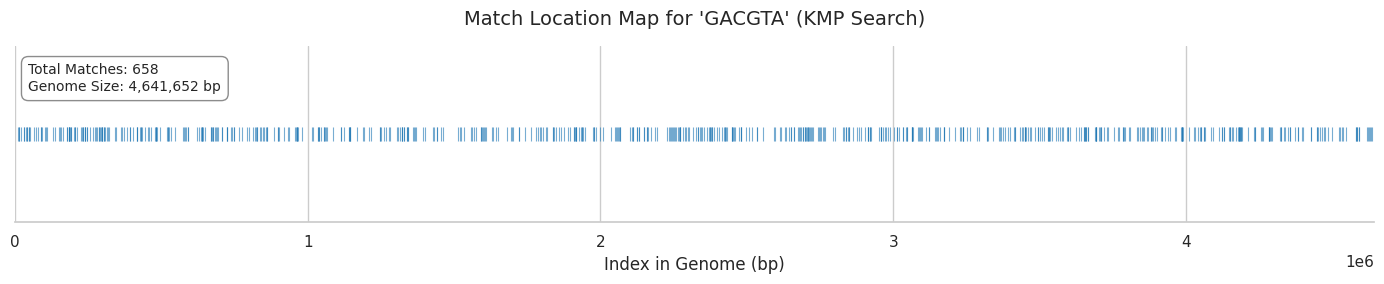

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

# Ensure local modules can be imported
sys.path.append(os.path.dirname(os.path.abspath("")))
from kmp import KMP
from utils import read_fasta_single_sequence

# ==========================================
#  CONFIGURATION
# ==========================================
# Dataset path
DATASET_PATH = "/home/rishabh/Desktop/sem3/aad/project/STARK/DnA_dataset/ncbi_dataset/data/GCA_000005845.2/GCA_000005845.2_ASM584v2_genomic.fna"

# Motif to find
TARGET_MOTIF = "GACGTA"

# Output directory for saving the graph
OUTPUT_DIR = "graphs"
# ==========================================

def plot_match_locations(sequence_length, positions, pattern_name):
    """
    Visualizes the exact locations of pattern matches as a linear map (Rug Plot).
    Matches the style of 'Graph 4: Match Location Map'.
    """
    if not positions:
        print("No matches to plot.")
        return

    # create a wide, short figure to represent the linear genome
    plt.figure(figsize=(14, 3))
    
    # Plot matches as vertical ticks on a single line (y=1)
    # We use a scatter plot with the pipe '|' marker to create the rug effect
    sns.scatterplot(
        x=positions,
        y=[1] * len(positions),
        marker="|",
        s=100,             # Size of the marker
        linewidth=0.8,     # Thickness of the line
        color='#1f77b4',   # Standard blue
        alpha=0.6          # Slight transparency to show density
    )

    # Formatting the axes
    plt.title(f"Match Location Map for '{pattern_name}' (KMP Search)", fontsize=14, pad=15)
    plt.xlabel("Index in Genome (bp)", fontsize=12)
    
    # Set X-axis limit to the full genome length
    plt.xlim(0, sequence_length)
    
    # Remove Y-axis ticks and labels (they are meaningless here)
    plt.yticks([])
    plt.ylim(0.9, 1.1) # Constrain Y to center the markers

    # Clean up the box spines for a cleaner look
    ax = plt.gca()
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add a text box with statistics
    stats_text = (
        f"Total Matches: {len(positions):,}\n"
        f"Genome Size: {sequence_length:,} bp"
    )
    plt.text(0.01, 0.9, stats_text, transform=ax.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.9))

    plt.tight_layout()

    # Save the figure
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    output_path = os.path.join(OUTPUT_DIR, f"match_location_map_{pattern_name}.png")
    plt.savefig(output_path, dpi=150)
    print(f"Graph saved to {output_path}")
    
    plt.show()

# --- Main Execution Flow ---

# 1. Load Data
if not os.path.exists(DATASET_PATH):
    print(f"Dataset not found at: {DATASET_PATH}")
    genome = ""
else:
    print(f"Loading sequence from: {DATASET_PATH} ...")
    try:
        genome = read_fasta_single_sequence(DATASET_PATH)
        print(f"Successfully loaded {len(genome):,} bp sequence.")
    except Exception as e:
        print(f"Error reading file: {e}")
        genome = ""

if genome:
    # 2. Run KMP Search
    print(f"Searching for motif '{TARGET_MOTIF}' using KMP...")
    
    # Initialize KMP with pattern
    kmp_solver = KMP(TARGET_MOTIF)
    
    # Perform search
    matches = kmp_solver.search(genome)
    print(f"Found {len(matches):,} matches.")

    # 3. Visualize (Location Map)
    plot_match_locations(len(genome), matches, TARGET_MOTIF)
else:
    print("No genome sequence available to search.")

### About the next cell (Average across two folders)
- Set two directory variables: one for the NCBI dataset (with subfolders of genomes) and one for a synthetic dataset folder.
- Recursively walks both folders to find FASTA-like files (*.fna, *.fa, *.fasta), loads the first sequence from each, and times KMP vs Regex for a shared motif set.
- Aggregates mean ± SEM by pattern length for each dataset separately and saves two line charts to `graphs/`.
- You can limit workload via `MAX_FILES_PER_SET` (None = all files).

[NCBI] Processing 90 files from: /home/rishabh/Desktop/sem3/aad/project/STARK/DnA_dataset/ncbi_dataset/data
[Synthetic] Processing 20 files from: /home/rishabh/Desktop/sem3/aad/project/STARK/KMP/dataset
[NCBI] Chart saved to graphs/graph_avg_ncbi.png


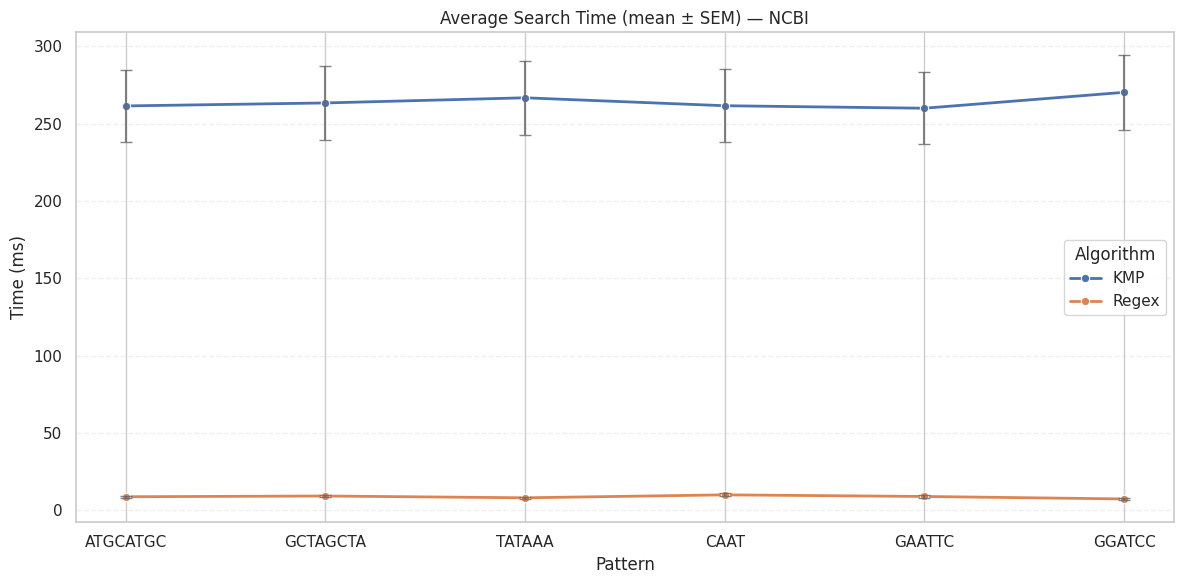

[Synthetic] Chart saved to graphs/graph_avg_synthetic.png


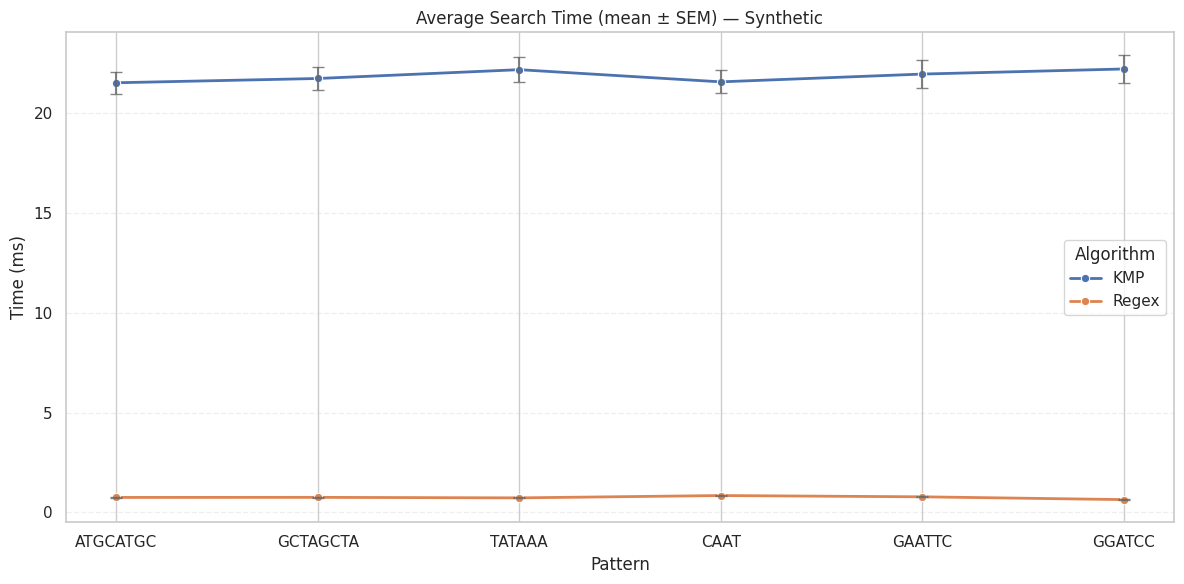


Coverage by dataset:
- NCBI: files=90 timings=1,080
- Synthetic: files=20 timings=240


In [19]:
# Average KMP vs Regex across two dataset folders (NCBI + Synthetic)
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from kmp import KMP
from utils import read_fasta_sequences_only

# ----------------------------
# Configuration
# ----------------------------
# 1) NCBI dataset (has subfolders for each genome)
#    We'll try to auto-detect; override manually if needed.
try:
    NCBI_DIR = detect_dataset_root()  # defined earlier in this notebook
except NameError:
    NCBI_DIR = None

# 2) Synthetic dataset folder (flat or nested). Defaults to './dataset'.
SYNTH_DIR = os.path.abspath(os.path.join(os.getcwd(), 'dataset'))

# Shared motifs to benchmark
PATTERNS = ['ATGCATGC', 'GCTAGCTA', 'TATAAA', 'CAAT', 'GAATTC', 'GGATCC']

# Optional: cap number of files processed per dataset to keep runs fast. Use None for all.
MAX_FILES_PER_SET = None  # e.g., set to 10 for a quick run

# Output dir
OUTPUT_DIR = 'graphs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------------
# Helpers
# ----------------------------
VALID_EXTS = {'.fna', '.fa', '.fasta'}

def _is_fasta_like(path: str) -> bool:
    ext = os.path.splitext(path)[1].lower()
    return ext in VALID_EXTS

def list_fasta_files(root: str) -> list:
    files = []
    for r, _, fs in os.walk(root):
        for fn in fs:
            fp = os.path.join(r, fn)
            if _is_fasta_like(fp):
                files.append(fp)
    return sorted(files)

def time_searches_over_folder(label: str, root: str, patterns: list, max_files: int | None = None) -> pd.DataFrame:
    rows = []
    if not root or not os.path.exists(root):
        print(f"[skip] {label}: folder not found -> {root}")
        return pd.DataFrame(columns=['Dataset','Genome','Pattern','Algo','Time (ms)','Matches'])
    files = list_fasta_files(root)
    if not files:
        print(f"[warn] {label}: no FASTA-like files under {root}")
        return pd.DataFrame(columns=['Dataset','Genome','Pattern','Algo','Time (ms)','Matches'])
    if max_files is not None:
        files = files[:max_files]
    print(f"[{label}] Processing {len(files)} files from: {root}")

    for i, fp in enumerate(files, 1):
        fname = os.path.basename(fp)
        try:
            seqs = read_fasta_sequences_only(fp)
            if not seqs:
                print(f"  [warn] {label}: no sequences in {fname}")
                continue
            text = seqs[0]
        except Exception as e:
            print(f"  [skip] {label}: cannot read {fname}: {e}")
            continue

        for patt in patterns:
            # KMP timing
            try:
                k = KMP(patt)
                t0 = time.time()
                k_positions = k.search(text)
                t1 = time.time()
                rows.append({
                    'Dataset': label,
                    'Genome': fname,
                    'Pattern': patt,
                    'Algo': 'KMP',
                    'Time (ms)': (t1 - t0) * 1000,
                    'Matches': len(k_positions),
                })
            except Exception as e:
                print(f"    [err] KMP on {fname} / {patt}: {e}")

            # Regex timing
            try:
                pat_re = re.compile(patt)
                t0 = time.time()
                r_positions = [mm.start() for mm in pat_re.finditer(text)]
                t1 = time.time()
                rows.append({
                    'Dataset': label,
                    'Genome': fname,
                    'Pattern': patt,
                    'Algo': 'Regex',
                    'Time (ms)': (t1 - t0) * 1000,
                    'Matches': len(r_positions),
                })
            except Exception as e:
                print(f"    [err] Regex on {fname} / {patt}: {e}")

    return pd.DataFrame(rows)

# ----------------------------
# Run for both folders
# ----------------------------
all_frames = []
if NCBI_DIR:
    df_ncbi = time_searches_over_folder('NCBI', NCBI_DIR, PATTERNS, MAX_FILES_PER_SET)
    if not df_ncbi.empty:
        all_frames.append(df_ncbi)
else:
    print("[info] NCBI_DIR not detected. Set it manually if you want to include NCBI.")

if os.path.exists(SYNTH_DIR):
    df_synth = time_searches_over_folder('Synthetic', SYNTH_DIR, PATTERNS, MAX_FILES_PER_SET)
    if not df_synth.empty:
        all_frames.append(df_synth)
else:
    print(f"[info] Synthetic folder not found: {SYNTH_DIR}")

if not all_frames:
    print("No data collected from either folder.")
else:
    df_all = pd.concat(all_frames, ignore_index=True)
    # Stats per dataset
    summary = (
        df_all.groupby(['Dataset','Algo','Pattern'], as_index=False)['Time (ms)']
              .agg(mean='mean', std='std', count='count')
    )
    summary['std'] = summary['std'].fillna(0.0)
    summary['count'] = summary['count'].clip(lower=1)
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])

    order = PATTERNS
    index_map = {p: i for i, p in enumerate(order)}
    summary['pattern_index'] = summary['Pattern'].map(index_map)

    # Plot per dataset
    for dataset, sub in summary.groupby('Dataset'):
        sub = sub.sort_values(['Algo','pattern_index'])
        plt.figure(figsize=(12,6))
        ax = sns.lineplot(
            data=sub, x='pattern_index', y='mean', hue='Algo', marker='o', linewidth=2
        )
        # Error bars
        for algo, sub2 in sub.groupby('Algo'):
            sub2 = sub2.sort_values('pattern_index')
            ax.errorbar(sub2['pattern_index'], sub2['mean'], yerr=sub2['sem'], fmt='none',
                        ecolor='#666666', elinewidth=1.5, capsize=4, alpha=0.8)
        ax.set_title(f"Average Search Time (mean ± SEM) — {dataset}")
        ax.set_xlabel('Pattern')
        ax.set_ylabel('Time (ms)')
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(order, rotation=0)
        ax.grid(True, axis='y', ls='--', alpha=0.3)
        ax.legend(title='Algorithm')
        plt.tight_layout()
        out_path = os.path.join(OUTPUT_DIR, f"graph_avg_{dataset.lower()}.png")
        plt.savefig(out_path, dpi=200)
        print(f"[{dataset}] Chart saved to {out_path}")
        plt.show()

    # Coverage summary
    print('\nCoverage by dataset:')
    for dataset, sub in df_all.groupby('Dataset'):
        print(f"- {dataset}: files={sub['Genome'].nunique()} timings={len(sub):,}")


### About the next cell (Combined timing + average across both folders)
- Measures processing time for each folder (NCBI and Synthetic) and the total time.
- Reuses the earlier helper to walk all files, run KMP vs Regex for shared motifs, and collect timings.
- Aggregates mean ± SEM across ALL files from both folders together and saves a single chart to `graphs/`.
- Prints a compact summary: per-folder time, total time, unique files processed, and per-pattern mean table.

[NCBI] Processing 90 files from: /home/rishabh/Desktop/sem3/aad/project/STARK/DnA_dataset/ncbi_dataset/data
[Synthetic] Processing 20 files from: /home/rishabh/Desktop/sem3/aad/project/STARK/KMP/dataset
Combined chart saved to graphs/graph_avg_all_datasets.png


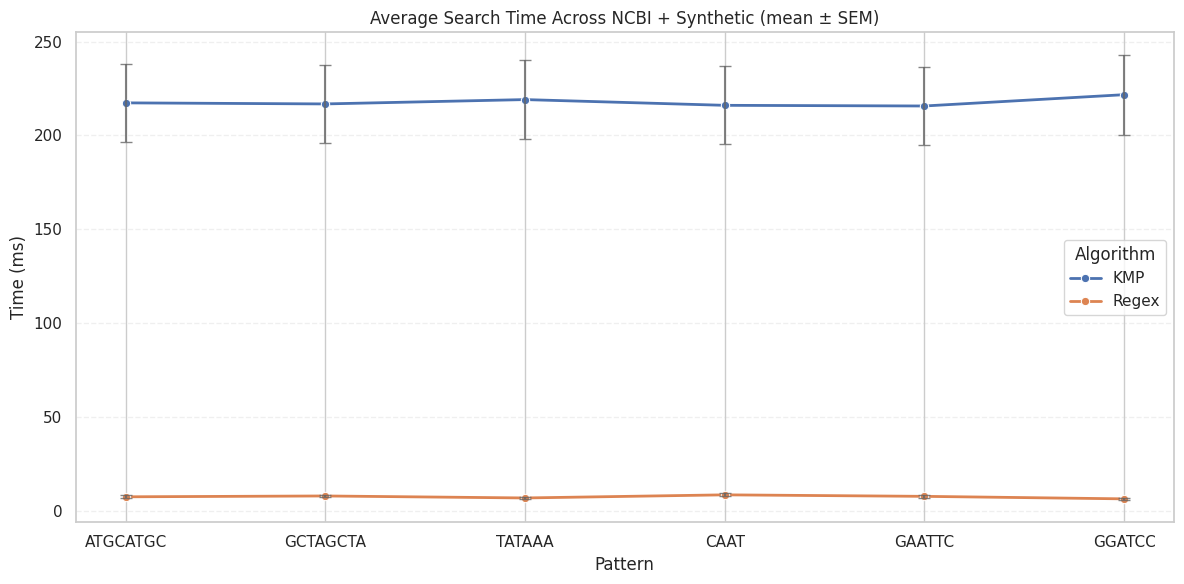


Processing time by dataset:
- NCBI: 147.66s
- Synthetic: 2.73s
Total processing time: 150.40s
Files processed (unique): 110 | Total timings: 1,320

Per-pattern mean times (ms) across ALL datasets:
Algo          KMP  Regex
Pattern                 
ATGCATGC  217.308  7.351
CAAT      215.996  8.398
GAATTC    215.644  7.593
GCTAGCTA  216.741  7.801
GGATCC    221.668  6.260
TATAAA    219.054  6.738


In [20]:
# Combined timing and averaged results across NCBI + Synthetic
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required globals exist or set sensible defaults
try:
    NCBI_DIR
except NameError:
    try:
        NCBI_DIR = detect_dataset_root()
    except NameError:
        NCBI_DIR = None

try:
    SYNTH_DIR
except NameError:
    SYNTH_DIR = os.path.abspath(os.path.join(os.getcwd(), 'dataset'))

try:
    PATTERNS
except NameError:
    PATTERNS = ['ATGCATGC', 'GCTAGCTA', 'TATAAA', 'CAAT', 'GAATTC', 'GGATCC']

try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = 'graphs'

os.makedirs(OUTPUT_DIR, exist_ok=True)

if 'time_searches_over_folder' not in globals():
    print("Helper 'time_searches_over_folder' not found. Please run the previous averaging cell first.")
else:
    frames = []
    per_folder_times = {}

    t_total0 = time.time()

    # NCBI timings
    if NCBI_DIR:
        t0 = time.time()
        df_ncbi = time_searches_over_folder('NCBI', NCBI_DIR, PATTERNS, MAX_FILES_PER_SET if 'MAX_FILES_PER_SET' in globals() else None)
        per_folder_times['NCBI'] = time.time() - t0
        if not df_ncbi.empty:
            frames.append(df_ncbi)
    else:
        print("[info] NCBI_DIR not set or not found; skipping NCBI.")

    # Synthetic timings
    if os.path.exists(SYNTH_DIR):
        t0 = time.time()
        df_synth = time_searches_over_folder('Synthetic', SYNTH_DIR, PATTERNS, MAX_FILES_PER_SET if 'MAX_FILES_PER_SET' in globals() else None)
        per_folder_times['Synthetic'] = time.time() - t0
        if not df_synth.empty:
            frames.append(df_synth)
    else:
        print(f"[info] Synthetic folder not found: {SYNTH_DIR}")

    t_total = time.time() - t_total0

    if not frames:
        print("No data collected from either folder.")
    else:
        df_all = pd.concat(frames, ignore_index=True)

        # Aggregate across BOTH datasets together (no dataset split)
        summary_all = (
            df_all.groupby(['Algo', 'Pattern'], as_index=False)['Time (ms)']
                  .agg(mean='mean', std='std', count='count')
        )
        summary_all['std'] = summary_all['std'].fillna(0.0)
        summary_all['count'] = summary_all['count'].clip(lower=1)
        summary_all['sem'] = summary_all['std'] / np.sqrt(summary_all['count'])

        order = PATTERNS
        index_map = {p: i for i, p in enumerate(order)}
        summary_all['pattern_index'] = summary_all['Pattern'].map(index_map)
        summary_all = summary_all.sort_values(['Algo', 'pattern_index'])

        # Plot combined mean ± SEM across all datasets
        plt.figure(figsize=(12, 6))
        ax = sns.lineplot(data=summary_all, x='pattern_index', y='mean', hue='Algo', marker='o', linewidth=2)
        for algo, sub in summary_all.groupby('Algo'):
            sub = sub.sort_values('pattern_index')
            ax.errorbar(sub['pattern_index'], sub['mean'], yerr=sub['sem'], fmt='none',
                        ecolor='#666666', elinewidth=1.5, capsize=4, alpha=0.8)
        ax.set_title('Average Search Time Across NCBI + Synthetic (mean ± SEM)')
        ax.set_xlabel('Pattern')
        ax.set_ylabel('Time (ms)')
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(order, rotation=0)
        ax.grid(True, axis='y', ls='--', alpha=0.3)
        ax.legend(title='Algorithm')
        plt.tight_layout()
        out_all = os.path.join(OUTPUT_DIR, 'graph_avg_all_datasets.png')
        plt.savefig(out_all, dpi=200)
        print(f"Combined chart saved to {out_all}")
        plt.show()

        # Print timing and coverage summaries
        print('\nProcessing time by dataset:')
        for k, v in per_folder_times.items():
            print(f"- {k}: {v:.2f}s")
        print(f"Total processing time: {t_total:.2f}s")
        print(f"Files processed (unique): {df_all['Genome'].nunique()} | Total timings: {len(df_all):,}")
        print("\nPer-pattern mean times (ms) across ALL datasets:")
        print(summary_all.pivot(index='Pattern', columns='Algo', values='mean').round(3).to_string())
